# **Assignment 2**

Please enter your **name, surname** and **student number** instead of `"NAME-HERE"`, `"SURNAME-HERE"`, `"NUMBER-HERE"` below.

In [1]:
student = {
    'name' : "Fatma" ,
    'surname' : "Döner",
    'studentNumber' : "2282986"
}

print(student)

{'name': 'Fatma', 'surname': 'Döner', 'studentNumber': '2282986'}


**Reminder: General Rules \& Submission Guidelines**

* Your work should be original and must be completed individually.
* The use of external sources must be properly cited.
* All coding must be done individually, and plagiarism will not be tolerated.
* Late submissions will incur a penalty unless an extension is granted by the instructor.
* Use the template notebook for your answers.
* Your assignment should be submitted as one and only one notebook file (.ipynb). Do not change the name of the file but do not forget to fill your name in the notebook.


##**Assignment Overview**

In this assignment, you will engage with two distinct machine learning problems. The first part focuses on ensemble learning techniques, and the second part on training a neural network using the Keras library, with an emphasis on hyperparameter experimentation. You will use [Kaggle dataset](https://www.kaggle.com/datasets/gregorut/videogamesales/data) for both problems.

###**Part 1: Ensemble Learning**
In this part, you will apply ensemble learning methods to a selected dataset.

####**Task 1: XGBoost with Cross-Validation**
Develop a model using the XGBoost algorithm. Integrate cross-validation to evaluate its performance robustly. Report your findings and discuss how the cross-validation approach helped in tuning hyperparameters and understanding the model’s stability across different subsets of data.

In [43]:
# Import dataset which has name 'vgsales.csv'
import pandas as pd
data = pd.read_csv('vgsales.csv')

# Dataset has columns: Rank, Name, Platform, Year, Genre, Publisher, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


<Axes: xlabel='count', ylabel='Genre'>

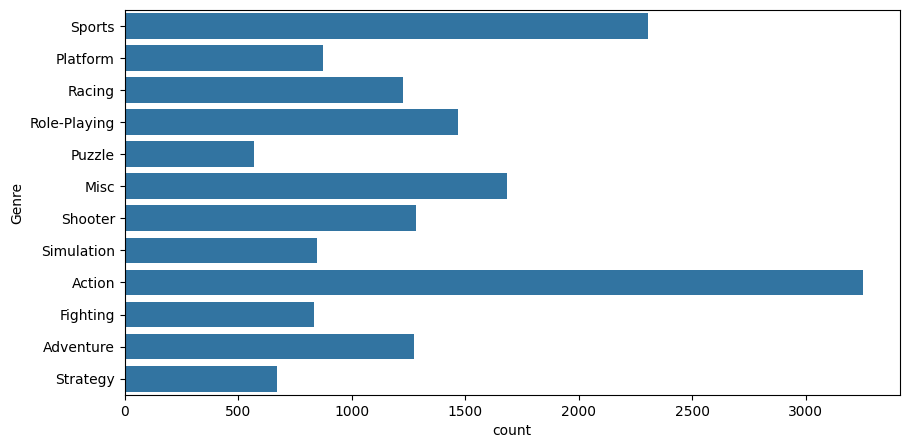

In [46]:
# Drop the rows which has missing values
data = data.dropna()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.countplot(data['Genre'])

<Axes: xlabel='count', ylabel='Platform'>

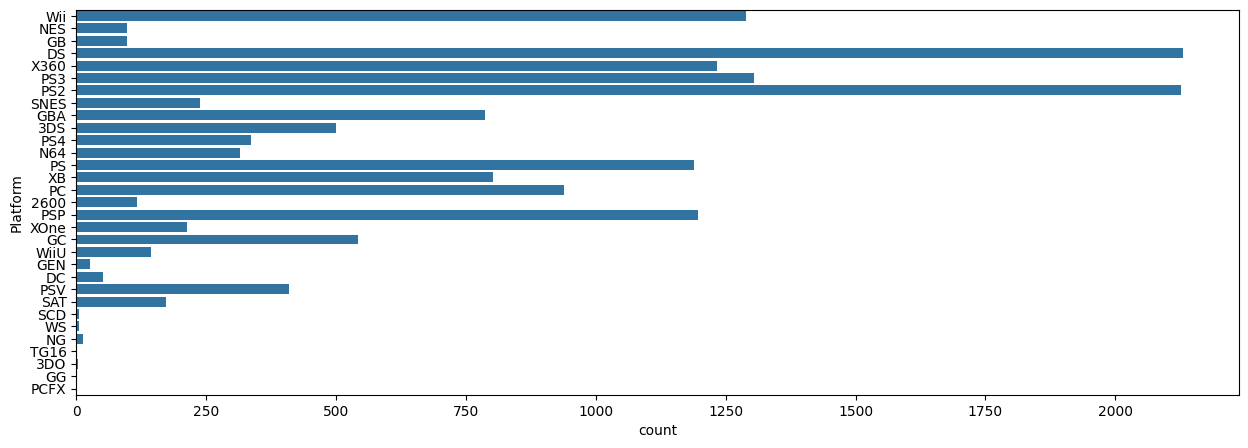

In [47]:
plt.figure(figsize=(15,5))
sns.countplot(data['Platform'])

<Axes: ylabel='Platform'>

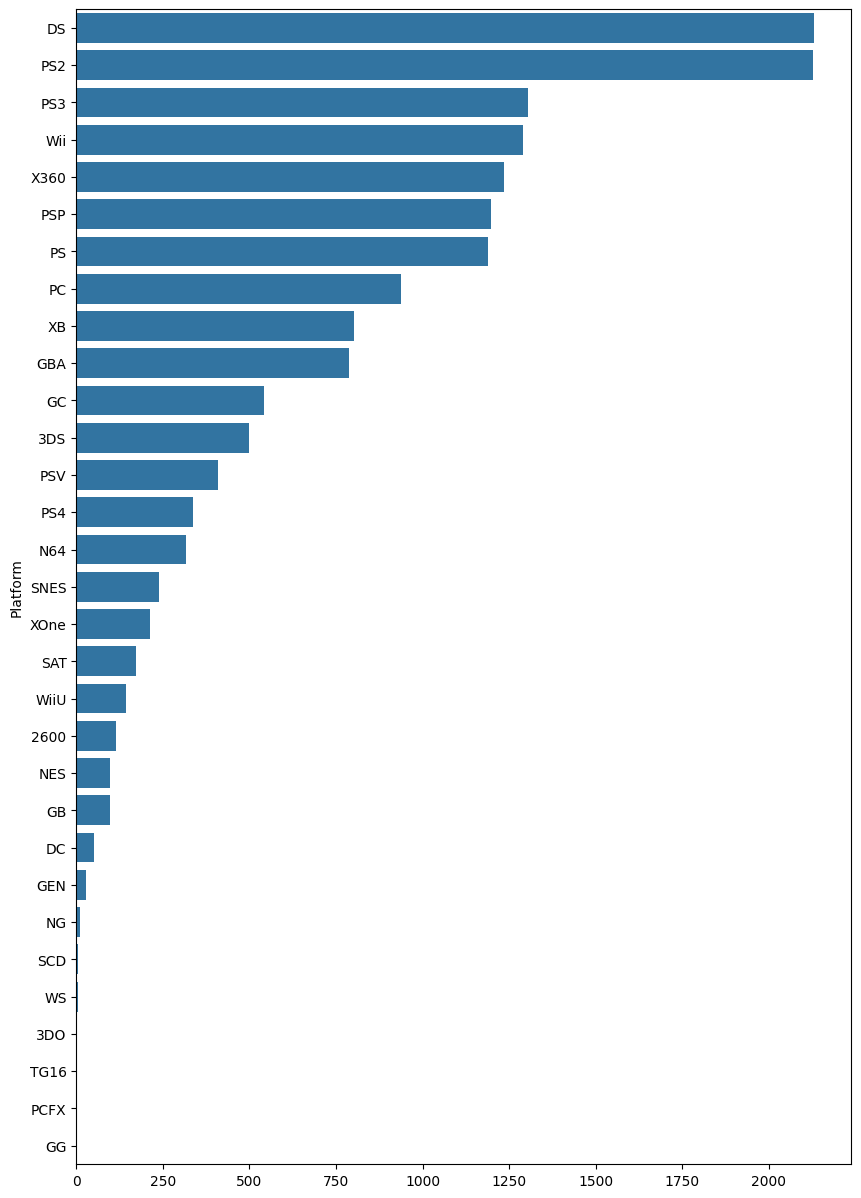

In [48]:
platGenre = pd.crosstab(data.Platform,data.Genre)
platGenreTotal =platGenre.sum(axis=1).sort_values(ascending = False)
plt.figure(figsize=(10,15))
sns.barplot(x=platGenreTotal.values,y=platGenreTotal.index)

<Axes: ylabel='Publisher'>

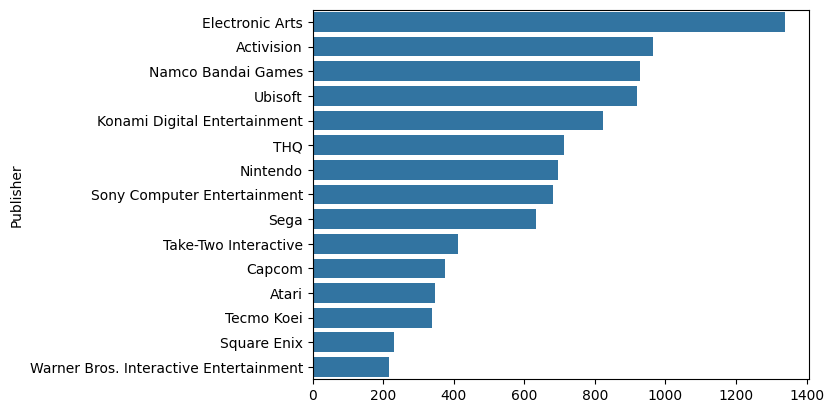

In [49]:
pub=data.groupby('Publisher')['Publisher'].count().sort_values(ascending = False).head(15)
sns.barplot(x=pub.values,y=pub.index)

In [50]:
# Convert categorical variables into numerical variables
from sklearn import preprocessing, model_selection
for c in data.columns:
    if data[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(data[c].values))
        data[c] = lbl.transform(list(data[c].values))

data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,10849,26,2006.0,10,359,41.49,29.02,3.77,8.46,82.74
1,2,9201,11,1985.0,4,359,29.08,3.58,6.81,0.77,40.24
2,3,5493,26,2008.0,6,359,15.85,12.88,3.79,3.31,35.82
3,4,10851,26,2009.0,10,359,15.75,11.01,3.28,2.96,33.00
4,5,7247,5,1996.0,7,359,11.27,8.89,10.22,1.00,31.37


Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

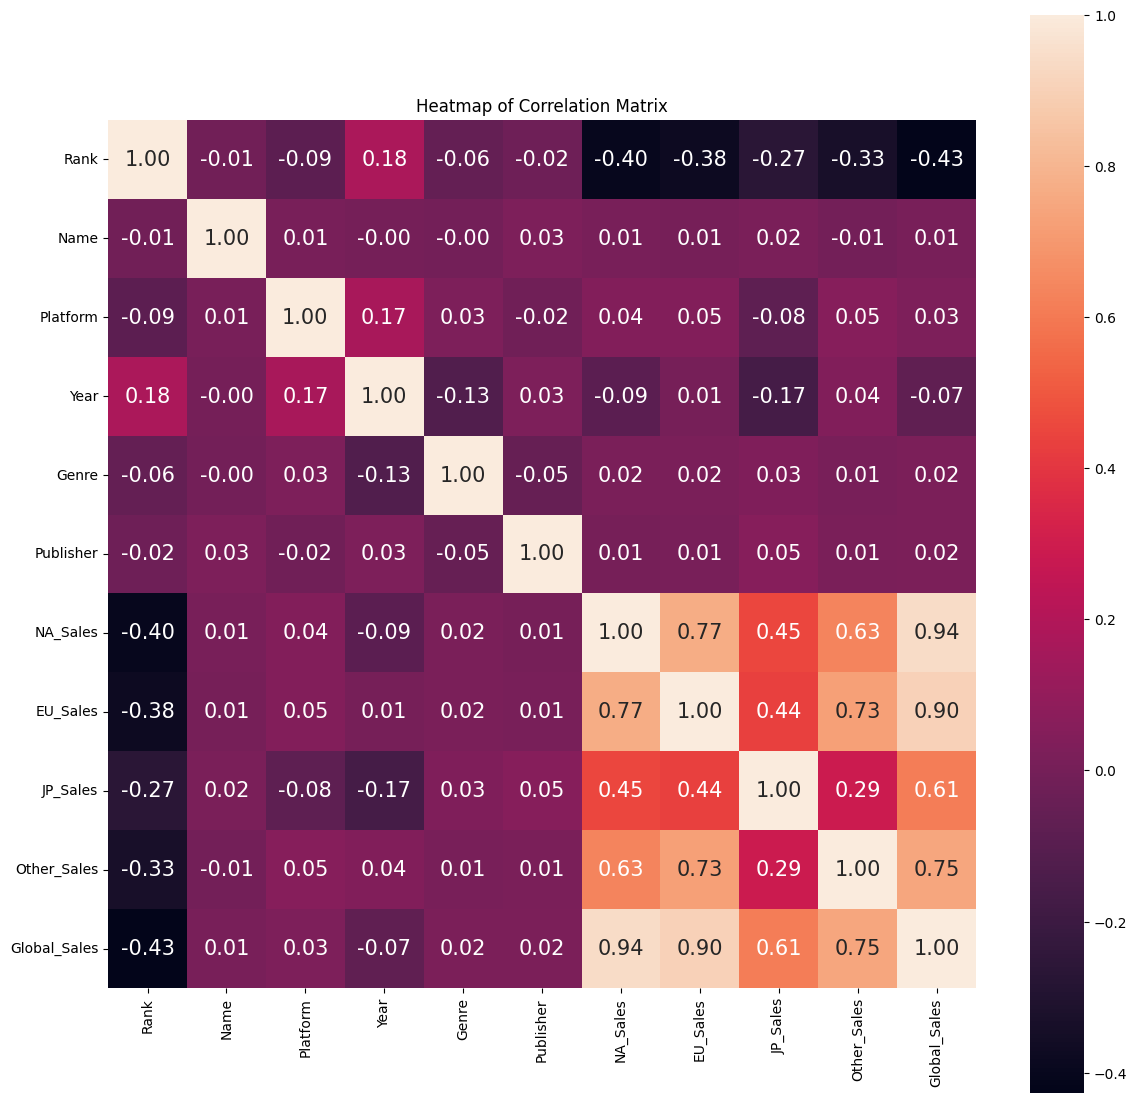

In [52]:
corr=data.corr()
corr = (corr)
plt.figure(figsize=(14,14))
ax = sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws=

{'size': 15},
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
ax.set_title('Heatmap of Correlation Matrix')

In [4]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
label = data.pop('Global_Sales')
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size = 0.2, random_state = 200)
data_train.shape, data_test.shape

((13032, 10), (3259, 10))

In [15]:
# Model with XGBoost
import xgboost as xgb
from sklearn.model_selection import KFold

# Set the parameters for the xgboost
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'alpha':0.001,
    'random_state': 42
}

# Create a DMatrix
dtrain = xgb.DMatrix(data_train, label_train)
dtest = xgb.DMatrix(data_test)

# Cross-validation
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False, nfold=5)

# Train the xgboost model
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

# Predict the Global Sales
label_pred = model.predict(dtest)

# Calculate the RMSE , Accuracy Score, F1 Score , Recall Score and Precision Score
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(label_test, label_pred)
print('Mean Squared Error: ', mse)

# Calculate RMSE
rmse = mse ** 0.5
print('Root Mean Squared Error: ', rmse)

[0]	train-rmse:1.49407	test-rmse:1.44071
[50]	train-rmse:0.33419	test-rmse:0.43069
[100]	train-rmse:0.12951	test-rmse:0.35624
[150]	train-rmse:0.06450	test-rmse:0.34219
[200]	train-rmse:0.04167	test-rmse:0.33866
[250]	train-rmse:0.03072	test-rmse:0.33658
[300]	train-rmse:0.02453	test-rmse:0.33580
[347]	train-rmse:0.02020	test-rmse:0.33537


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:26:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error:  0.05727978580659084
Root Mean Squared Error:  0.23933195734500406


#####**Feature Importance Analysis**
As part of your model evaluation, extract and analyze the important features identified by the XGBoost model. Discuss how these features contribute to the model's predictions and their overall importance in the dataset.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

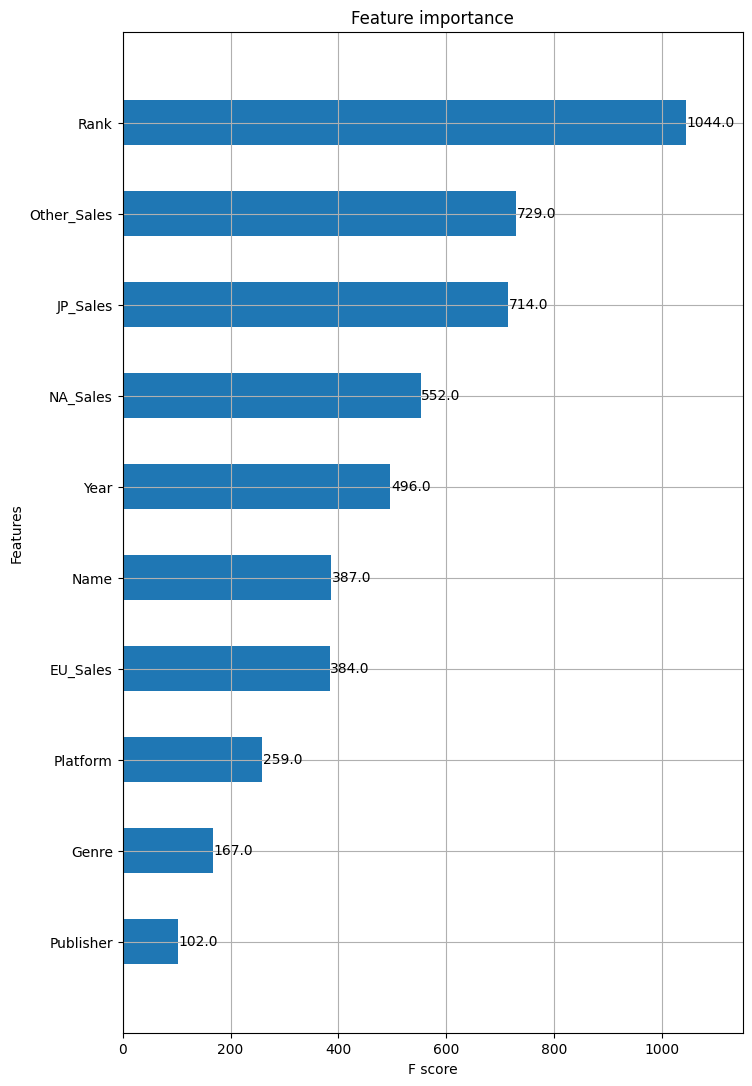

In [16]:
# Feature Importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

*Your discussion here*

####**Task 2: Stacking**
Create a stacking model using at least three different learning algorithms, including XGBoost as a base learner. Evaluate and compare the performance of your stacking model with the XGBoost-only model.

In [17]:
# Stacking Model with three different base-learning models: Random Forest, Gradient Boosting and XGBoost
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# Create the base models
base_models = [
    ('RandomForestRegressor', RandomForestRegressor(n_estimators=10, random_state=42)),
    ('GradientBoostingRegressor', GradientBoostingRegressor(n_estimators=10, random_state=42)),
    ('XGBRegressor', xgb.XGBRegressor(n_estimators=10, random_state=42))
]

# Create the stacking model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

# Train the stacking model
stacking_model.fit(data_train, label_train)

# Predict the Global Sales
label_pred = stacking_model.predict(data_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse_stacking = mean_squared_error(label_test, label_pred)
print('Mean Squared Error: ', mse_stacking)

# Calculate RMSE
rmse_stacking = mse_stacking ** 0.5
print('Root Mean Squared Error: ', rmse_stacking)

# Compare the RMSE of the XGBoost and Stacking models in a table
import pandas as pd

data = {
    'Model': ['XGBoost', 'Stacking'],
    'RMSE': [rmse, rmse_stacking]
}

df = pd.DataFrame(data)
df

Mean Squared Error:  0.02246840506167973
Root Mean Squared Error:  0.14989464654109477


,Model,RMSE
0,XGBoost,0.239332
1,Stacking,0.149895


###**Part 2: Neural Networks with Keras**
Train a neural network using Keras, focusing on the effects of various hyperparameters. Discuss your findings and how the hyperparameters are effect the model evaluation metrics (F1, recall et.c)

In [19]:
# Train Naural Network Model with Keras
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model = Sequential()
model.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred = model.predict(data_test)

Epoch 1/100
326/326 [==============================] - 3s 3ms/step - loss: 15395.5527 - val_loss: 313.4990
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 159.6636 - val_loss: 91.4925
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: 76.1522 - val_loss: 53.0138
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: 59.0132 - val_loss: 60.3572
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: 48.6938 - val_loss: 29.0387
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 47.8543 - val_loss: 72.6662
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: 50.3109 - val_loss: 123.6238
Epoch 8/100
326/326 [==============================] - 1s 4ms/step - loss: 51.3251 - val_loss: 52.0419
Epoch 9/100
326/326 [==============================] - 2s 5ms/step - loss: 57.0251 - val_loss: 29.8503
Epoch 10/100
326/326 [==============================] - 1s 4ms/step

In [20]:
# Evaluate the model
from sklearn.metrics import mean_squared_error
mse_nn = mean_squared_error(label_test, label_pred)
print('Mean Squared Error: ', mse_nn)

# Calculate RMSE
rmse_nn = mse_nn ** 0.5
print('Root Mean Squared Error: ', rmse_nn)

Mean Squared Error:  0.8377300403005188
Root Mean Squared Error:  0.9152759366991567


*Your discussion here*

####**Task 1: Weight Initialization**
Experiment with different weight initialization methods (Uniform, Xavier, Zero). Observe and discuss their impact on model performance.
You can check [this link](https://www.deeplearning.ai/ai-notes/initialization).

In [21]:
# Weight Initialization with: Uniform, Xavier and Zero
from keras.initializers import RandomUniform, glorot_normal, Zeros

# Create the model with Uniform weight initialization
model_uniform = Sequential()
model_uniform.add(Dense(64, input_dim=data_train.shape[1], activation='relu', kernel_initializer=RandomUniform()))
model_uniform.add(Dense(32, activation='relu', kernel_initializer=RandomUniform()))
model_uniform.add(Dense(1, activation='linear', kernel_initializer=RandomUniform()))

# Compile the model
model_uniform.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_uniform.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_uniform = model_uniform.predict(data_test)

Epoch 1/100
326/326 [==============================] - 2s 4ms/step - loss: 1.6341 - val_loss: 0.7512
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 1.1091 - val_loss: 0.9758
Epoch 3/100
326/326 [==============================] - 1s 3ms/step - loss: 1.0752 - val_loss: 0.5214
Epoch 4/100
326/326 [==============================] - 1s 4ms/step - loss: 0.8886 - val_loss: 0.4101
Epoch 5/100
326/326 [==============================] - 2s 6ms/step - loss: 0.7714 - val_loss: 0.6185
Epoch 6/100
326/326 [==============================] - 2s 6ms/step - loss: 0.9957 - val_loss: 0.3590
Epoch 7/100
326/326 [==============================] - 1s 3ms/step - loss: 0.7314 - val_loss: 0.2764
Epoch 8/100
326/326 [==============================] - 1s 4ms/step - loss: 0.6871 - val_loss: 0.3062
Epoch 9/100
326/326 [==============================] - 1s 4ms/step - loss: 0.6674 - val_loss: 0.2607
Epoch 10/100
326/326 [==============================] - 1s 3ms/step - loss: 0.6537 - val_lo

In [22]:
# Create the model with Xavier weight initialization
model_xavier = Sequential()
model_xavier.add(Dense(64, input_dim=data_train.shape[1], activation='relu', kernel_initializer=glorot_normal()))
model_xavier.add(Dense(32, activation='relu', kernel_initializer=glorot_normal()))
model_xavier.add(Dense(1, activation='linear', kernel_initializer=glorot_normal()))

# Compile the model
model_xavier.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_xavier.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_xavier = model_xavier.predict(data_test)

Epoch 1/100
326/326 [==============================] - 2s 3ms/step - loss: 52839.0859 - val_loss: 464.8921
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 265.2605 - val_loss: 190.7999
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: 149.1281 - val_loss: 136.5403
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: 108.7643 - val_loss: 104.0243
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: 82.2570 - val_loss: 76.4602
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 64.9823 - val_loss: 50.5790
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: 49.7065 - val_loss: 76.6516
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: 40.8171 - val_loss: 42.5342
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 37.1835 - val_loss: 32.2898
Epoch 10/100
326/326 [==============================] - 1s 3ms/

In [23]:
# Create the model with Zero weight initialization
model_zero = Sequential()
model_zero.add(Dense(64, input_dim=data_train.shape[1], activation='relu', kernel_initializer=Zeros()))
model_zero.add(Dense(32, activation='relu', kernel_initializer=Zeros()))
model_zero.add(Dense(1, activation='linear', kernel_initializer=Zeros()))

# Compile the model
model_zero.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_zero.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_zero = model_zero.predict(data_test)

Epoch 1/100
326/326 [==============================] - 4s 6ms/step - loss: 2.6639 - val_loss: 2.2839
Epoch 2/100
326/326 [==============================] - 2s 7ms/step - loss: 2.5391 - val_loss: 2.2260
Epoch 3/100
326/326 [==============================] - 2s 7ms/step - loss: 2.5016 - val_loss: 2.2140
Epoch 4/100
326/326 [==============================] - 3s 8ms/step - loss: 2.4932 - val_loss: 2.2132
Epoch 5/100
326/326 [==============================] - 2s 5ms/step - loss: 2.4918 - val_loss: 2.2138
Epoch 6/100
326/326 [==============================] - 1s 4ms/step - loss: 2.4918 - val_loss: 2.2140
Epoch 7/100
326/326 [==============================] - 2s 6ms/step - loss: 2.4917 - val_loss: 2.2139
Epoch 8/100
326/326 [==============================] - 1s 4ms/step - loss: 2.4917 - val_loss: 2.2138
Epoch 9/100
326/326 [==============================] - 2s 7ms/step - loss: 2.4917 - val_loss: 2.2139
Epoch 10/100
326/326 [==============================] - 2s 8ms/step - loss: 2.4918 - val_lo

In [24]:
# Evaluate the models and compare the RMSE values in a table
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for Uniform weight initialization
mse_uniform = mean_squared_error(label_test, label_pred_uniform)
rmse_uniform = mse_uniform ** 0.5

# Calculate RMSE for Xavier weight initialization
mse_xavier = mean_squared_error(label_test, label_pred_xavier)
rmse_xavier = mse_xavier ** 0.5

# Calculate RMSE for Zero weight initialization
mse_zero = mean_squared_error(label_test, label_pred_zero)
rmse_zero = mse_zero ** 0.5

data = {
    'Weight Initialization': ['Uniform', 'Xavier', 'Zero'],
    'RMSE': [rmse_uniform, rmse_xavier, rmse_zero]
}

df = pd.DataFrame(data)
df

,Weight Initialization,RMSE
0,Uniform,0.237892
1,Xavier,1.096336
2,Zero,1.593082


*Your discussion here*

Uniform best

####**Task 2: Varying the Number of Layers**
Modify the number of layers in your network (1 hidden layer, 3 hidden layers, 5 hidden layers). Explore and discuss the effects on performance.

In [25]:
# Varying the number of hidden layers: 1, 3 and 5
# Create the model with 1 hidden layer
model_1 = Sequential()
model_1.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Compile the model
model_1.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_1.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_1 = model_1.predict(data_test)

Epoch 1/100
326/326 [==============================] - 1s 3ms/step - loss: 47944.3555 - val_loss: 1585.9435
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 1006.4672 - val_loss: 626.6425
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: 455.6383 - val_loss: 307.5376
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: 203.4928 - val_loss: 130.2822
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: 116.3424 - val_loss: 93.7375
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 93.9014 - val_loss: 81.8058
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: 80.9618 - val_loss: 65.7291
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: 66.4202 - val_loss: 59.1550
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 57.3610 - val_loss: 60.5599
Epoch 10/100
326/326 [==============================] - 1s 2

In [26]:
# Create the model with 3 hidden layers
model_3 = Sequential()
model_3.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Compile the model
model_3.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_3.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_3 = model_3.predict(data_test)

Epoch 1/100
326/326 [==============================] - 2s 3ms/step - loss: 5075.8882 - val_loss: 81.9516
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 44.4230 - val_loss: 27.8823
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: 20.0025 - val_loss: 16.9349
Epoch 4/100
326/326 [==============================] - 1s 3ms/step - loss: 14.4870 - val_loss: 11.2425
Epoch 5/100
326/326 [==============================] - 1s 3ms/step - loss: 11.7492 - val_loss: 10.0811
Epoch 6/100
326/326 [==============================] - 1s 4ms/step - loss: 11.6838 - val_loss: 8.5614
Epoch 7/100
326/326 [==============================] - 1s 3ms/step - loss: 10.7433 - val_loss: 6.6403
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: 9.4622 - val_loss: 6.7878
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 26.6954 - val_loss: 6.4764
Epoch 10/100
326/326 [==============================] - 1s 2ms/step - loss: 

In [27]:
# Create the model with 5 hidden layers
model_5 = Sequential()
model_5.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(16, activation='relu'))
model_5.add(Dense(8, activation='relu'))
model_5.add(Dense(4, activation='relu'))
model_5.add(Dense(1, activation='linear'))

# Compile the model
model_5.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_5.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_5 = model_5.predict(data_test)

Epoch 1/100
326/326 [==============================] - 3s 3ms/step - loss: 22804.6035 - val_loss: 24.3342
Epoch 2/100
326/326 [==============================] - 1s 3ms/step - loss: 8.8195 - val_loss: 2.2999
Epoch 3/100
326/326 [==============================] - 1s 3ms/step - loss: 2.0267 - val_loss: 1.4640
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: 1.6403 - val_loss: 1.3387
Epoch 5/100
326/326 [==============================] - 1s 3ms/step - loss: 1.5807 - val_loss: 1.3264
Epoch 6/100
326/326 [==============================] - 1s 5ms/step - loss: 1.5750 - val_loss: 1.2973
Epoch 7/100
326/326 [==============================] - 1s 4ms/step - loss: 1.5493 - val_loss: 1.2749
Epoch 8/100
326/326 [==============================] - 1s 3ms/step - loss: 1.5399 - val_loss: 1.2684
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 1.5235 - val_loss: 1.2401
Epoch 10/100
326/326 [==============================] - 1s 2ms/step - loss: 1.5346 - v

In [28]:
# Evaluate the models and compare the RMSE values in a table
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for 1 hidden layer
mse_1 = mean_squared_error(label_test, label_pred_1)
rmse_1 = mse_1 ** 0.5

# Calculate RMSE for 3 hidden layers
mse_3 = mean_squared_error(label_test, label_pred_3)
rmse_3 = mse_3 ** 0.5

# Calculate RMSE for 5 hidden layers
mse_5 = mean_squared_error(label_test, label_pred_5)
rmse_5 = mse_5 ** 0.5

data = {
    'Number of Hidden Layers': [1, 3, 5],
    'RMSE': [rmse_1, rmse_3, rmse_5]
}

df = pd.DataFrame(data)
df

,Number of Hidden Layers,RMSE
0,1,1.751295
1,3,0.373997
2,5,0.818760


*Your discussion here*

1 Hidden layer is best

####**Task 3: Activation Functions**
Test various activation functions (Relu, Leaky Relu, Sigmoid). Analyze and discuss their influence on learning and performance.

In [29]:
# Activation Functions: ReLU, Leaky ReLU and Sigmoid
from keras.layers import LeakyReLU

# Create the model with ReLU activation function
model_relu = Sequential()
model_relu.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_relu.add(Dense(32, activation='relu'))
model_relu.add(Dense(1, activation='linear'))

# Compile the model
model_relu.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_relu.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_relu = model_relu.predict(data_test)

Epoch 1/100
326/326 [==============================] - 2s 3ms/step - loss: 164118.7500 - val_loss: 631.7167
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 433.4483 - val_loss: 264.1796
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: 195.9927 - val_loss: 121.6907
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: 105.3257 - val_loss: 71.8010
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: 59.6475 - val_loss: 38.3349
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 34.7549 - val_loss: 23.9074
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: 22.2077 - val_loss: 17.2080
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: 17.8238 - val_loss: 15.3184
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 16.0133 - val_loss: 15.4420
Epoch 10/100
326/326 [==============================] - 1s 2ms/

In [30]:
# Create the model with Leaky ReLU activation function
model_leaky_relu = Sequential()
model_leaky_relu.add(Dense(64, input_dim=data_train.shape[1], activation=LeakyReLU()))
model_leaky_relu.add(Dense(32, activation=LeakyReLU()))
model_leaky_relu.add(Dense(1, activation='linear'))

# Compile the model
model_leaky_relu.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_leaky_relu.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_leaky_relu = model_leaky_relu.predict(data_test)

Epoch 1/100
326/326 [==============================] - 2s 3ms/step - loss: 13078.8594 - val_loss: 233.3223
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 179.8436 - val_loss: 143.3798
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: 87.1611 - val_loss: 63.7031
Epoch 4/100
326/326 [==============================] - 1s 3ms/step - loss: 60.8180 - val_loss: 49.9613
Epoch 5/100
326/326 [==============================] - 1s 3ms/step - loss: 44.8387 - val_loss: 41.9397
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 38.7883 - val_loss: 29.5858
Epoch 7/100
326/326 [==============================] - 1s 4ms/step - loss: 29.0008 - val_loss: 15.0997
Epoch 8/100
326/326 [==============================] - 1s 4ms/step - loss: 20.9343 - val_loss: 11.9887
Epoch 9/100
326/326 [==============================] - 1s 4ms/step - loss: 26.1923 - val_loss: 42.8179
Epoch 10/100
326/326 [==============================] - 1s 2ms/step

In [31]:
# Create the model with Sigmoid activation function
model_sigmoid = Sequential()
model_sigmoid.add(Dense(64, input_dim=data_train.shape[1], activation='sigmoid'))
model_sigmoid.add(Dense(32, activation='sigmoid'))
model_sigmoid.add(Dense(1, activation='linear'))

# Compile the model
model_sigmoid.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_sigmoid.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_sigmoid = model_sigmoid.predict(data_test)

Epoch 1/100
326/326 [==============================] - 1s 2ms/step - loss: 2.2689 - val_loss: 1.5472
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 1.6309 - val_loss: 1.2640
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: 1.4172 - val_loss: 1.1112
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: 1.3204 - val_loss: 1.0809
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: 1.2582 - val_loss: 0.9435
Epoch 6/100
326/326 [==============================] - 1s 3ms/step - loss: 1.1658 - val_loss: 0.8812
Epoch 7/100
326/326 [==============================] - 1s 3ms/step - loss: 1.1338 - val_loss: 0.8486
Epoch 8/100
326/326 [==============================] - 1s 4ms/step - loss: 1.0927 - val_loss: 0.8371
Epoch 9/100
326/326 [==============================] - 1s 3ms/step - loss: 1.0915 - val_loss: 0.7374
Epoch 10/100
326/326 [==============================] - 1s 2ms/step - loss: 1.0345 - val_lo

In [32]:
# Evaluate the models and compare the RMSE values in a table
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for ReLU activation function
mse_relu = mean_squared_error(label_test, label_pred_relu)
rmse_relu = mse_relu ** 0.5

# Calculate RMSE for Leaky ReLU activation function
mse_leaky_relu = mean_squared_error(label_test, label_pred_leaky_relu)
rmse_leaky_relu = mse_leaky_relu ** 0.5

# Calculate RMSE for Sigmoid activation function
mse_sigmoid = mean_squared_error(label_test, label_pred_sigmoid)
rmse_sigmoid = mse_sigmoid ** 0.5

data = {
    'Activation Function': ['ReLU', 'Leaky ReLU', 'Sigmoid'],
    'RMSE': [rmse_relu, rmse_leaky_relu, rmse_sigmoid]
}

df = pd.DataFrame(data)
df

,Activation Function,RMSE
0,ReLU,0.488826
1,Leaky ReLU,0.804099
2,Sigmoid,0.733450


*Your discussion here*

Best is ReLU

####**Task 4: Learning**
Test various learning rate on model convergence (0.01, 0.1, 0.5). Analyze and discuss their influence on learning and performance.

In [33]:
# Learning Rate: 0.01, 0.1 and 0.5
from keras.optimizers import Adam

# Create the model with learning rate 0.01
model_lr_001 = Sequential()
model_lr_001.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_lr_001.add(Dense(32, activation='relu'))
model_lr_001.add(Dense(1, activation='linear'))

# Compile the model
model_lr_001.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

# Train the model
model_lr_001.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_lr_001 = model_lr_001.predict(data_test)

Epoch 1/100
326/326 [==============================] - 2s 3ms/step - loss: 15380.0029 - val_loss: 41.5817
Epoch 2/100
326/326 [==============================] - 1s 4ms/step - loss: 18.3137 - val_loss: 8.7477
Epoch 3/100
326/326 [==============================] - 1s 3ms/step - loss: 6.5491 - val_loss: 6.1782
Epoch 4/100
326/326 [==============================] - 1s 3ms/step - loss: 4.0131 - val_loss: 2.8713
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: 2.9533 - val_loss: 2.5831
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 2.3133 - val_loss: 2.0804
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: 1.9023 - val_loss: 1.2404
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: 1.4584 - val_loss: 1.3087
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 1.3637 - val_loss: 0.8371
Epoch 10/100
326/326 [==============================] - 1s 2ms/step - loss: 1.4132 - 

In [34]:
# Create the model with learning rate 0.1
model_lr_01 = Sequential()
model_lr_01.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_lr_01.add(Dense(32, activation='relu'))
model_lr_01.add(Dense(1, activation='linear'))

# Compile the model
model_lr_01.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.1))

# Train the model
model_lr_01.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_lr_01 = model_lr_01.predict(data_test)

Epoch 1/100
326/326 [==============================] - 2s 3ms/step - loss: 657399.6250 - val_loss: 2.2172
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 2.4968 - val_loss: 2.2133
Epoch 3/100
326/326 [==============================] - 1s 3ms/step - loss: 2.4958 - val_loss: 2.2158
Epoch 4/100
326/326 [==============================] - 1s 4ms/step - loss: 2.4966 - val_loss: 2.2132
Epoch 5/100
326/326 [==============================] - 1s 4ms/step - loss: 2.4948 - val_loss: 2.2144
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 2.4953 - val_loss: 2.2132
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: 2.4985 - val_loss: 2.2150
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: 2.4996 - val_loss: 2.2132
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 2.5001 - val_loss: 2.2204
Epoch 10/100
326/326 [==============================] - 1s 2ms/step - loss: 2.4983 - v

In [35]:
# Create the model with learning rate 0.5
model_lr_05 = Sequential()
model_lr_05.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_lr_05.add(Dense(32, activation='relu'))
model_lr_05.add(Dense(1, activation='linear'))

# Compile the model
model_lr_05.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.5))

# Train the model
model_lr_05.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_lr_05 = model_lr_05.predict(data_test)

Epoch 1/100
326/326 [==============================] - 1s 3ms/step - loss: 2865074432.0000 - val_loss: 2.2700
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 2.5397 - val_loss: 2.2133
Epoch 3/100
326/326 [==============================] - 1s 3ms/step - loss: 2.5320 - val_loss: 2.2190
Epoch 4/100
326/326 [==============================] - 1s 3ms/step - loss: 2.5863 - val_loss: 2.4146
Epoch 5/100
326/326 [==============================] - 1s 3ms/step - loss: 2.5776 - val_loss: 2.2244
Epoch 6/100
326/326 [==============================] - 1s 4ms/step - loss: 2.6037 - val_loss: 2.2188
Epoch 7/100
326/326 [==============================] - 1s 3ms/step - loss: 2.6329 - val_loss: 2.2799
Epoch 8/100
326/326 [==============================] - 1s 3ms/step - loss: 2.5846 - val_loss: 2.2172
Epoch 9/100
326/326 [==============================] - 1s 3ms/step - loss: 2.5838 - val_loss: 2.8700
Epoch 10/100
326/326 [==============================] - 1s 3ms/step - loss: 2.6210

In [36]:
# Evaluate the models and compare the RMSE values in a table
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for learning rate 0.01
mse_lr_001 = mean_squared_error(label_test, label_pred_lr_001)
rmse_lr_001 = mse_lr_001 ** 0.5

# Calculate RMSE for learning rate 0.1
mse_lr_01 = mean_squared_error(label_test, label_pred_lr_01)
rmse_lr_01 = mse_lr_01 ** 0.5

# Calculate RMSE for learning rate 0.5
mse_lr_05 = mean_squared_error(label_test, label_pred_lr_05)
rmse_lr_05 = mse_lr_05 ** 0.5

data = {
    'Learning Rate': [0.01, 0.1, 0.5],
    'RMSE': [rmse_lr_001, rmse_lr_01, rmse_lr_05]
}

df = pd.DataFrame(data)
df

,Learning Rate,RMSE
0,0.01,1.594515
1,0.10,1.599691
2,0.50,1.616202


*Your discussion here*

Best is 0.01

####**Task 5: Optimization Algorithms**
Test different optimization algorithms (SGD, Adam, RmsProb). Analyze and discuss their influence on learning and performance.

In [37]:
# Optimizers: Adam, SGD and RMSprop
from keras.optimizers import SGD, RMSprop

# Create the model with Adam optimizer
model_adam = Sequential()
model_adam.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_adam.add(Dense(32, activation='relu'))
model_adam.add(Dense(1, activation='linear'))

# Compile the model
model_adam.compile(loss='mean_squared_error', optimizer=Adam())

# Train the model
model_adam.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_adam = model_adam.predict(data_test)

Epoch 1/100
326/326 [==============================] - 1s 3ms/step - loss: 10061.7559 - val_loss: 229.8089
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 164.6611 - val_loss: 104.7537
Epoch 3/100
326/326 [==============================] - 1s 3ms/step - loss: 103.2442 - val_loss: 88.1876
Epoch 4/100
326/326 [==============================] - 1s 3ms/step - loss: 76.0379 - val_loss: 44.5906
Epoch 5/100
326/326 [==============================] - 1s 3ms/step - loss: 58.3468 - val_loss: 46.4705
Epoch 6/100
326/326 [==============================] - 2s 5ms/step - loss: 55.1370 - val_loss: 25.6807
Epoch 7/100
326/326 [==============================] - 1s 4ms/step - loss: 105.9053 - val_loss: 24.2108
Epoch 8/100
326/326 [==============================] - 2s 7ms/step - loss: 450.5311 - val_loss: 43.0211
Epoch 9/100
326/326 [==============================] - 2s 6ms/step - loss: 40.4254 - val_loss: 29.2051
Epoch 10/100
326/326 [==============================] - 2s 5ms/s

In [38]:
# Create the model with SGD optimizer
model_sgd = Sequential()
model_sgd.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_sgd.add(Dense(32, activation='relu'))
model_sgd.add(Dense(1, activation='linear'))

# Compile the model
model_sgd.compile(loss='mean_squared_error', optimizer=SGD())

# Train the model
model_sgd.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_sgd = model_sgd.predict(data_test)

Epoch 1/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 10/100
326/326 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 11/100
326/326 [===========================

In [39]:
# Create the model with RMSprop optimizer
model_rmsprop = Sequential()
model_rmsprop.add(Dense(64, input_dim=data_train.shape[1], activation='relu'))
model_rmsprop.add(Dense(32, activation='relu'))
model_rmsprop.add(Dense(1, activation='linear'))

# Compile the model
model_rmsprop.compile(loss='mean_squared_error', optimizer=RMSprop())

# Train the model
model_rmsprop.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_rmsprop = model_rmsprop.predict(data_test)

Epoch 1/100
326/326 [==============================] - 2s 3ms/step - loss: 18777.6289 - val_loss: 10876.6035
Epoch 2/100
326/326 [==============================] - 1s 3ms/step - loss: 3466.0117 - val_loss: 4784.8384
Epoch 3/100
326/326 [==============================] - 1s 4ms/step - loss: 2350.5017 - val_loss: 544.6347
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: 1744.5253 - val_loss: 262.2534
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: 1204.3392 - val_loss: 121.5262
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 886.7674 - val_loss: 770.0891
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: 638.1284 - val_loss: 63.9040
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: 513.2209 - val_loss: 155.2984
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 425.4554 - val_loss: 706.1938
Epoch 10/100
326/326 [=========================

In [41]:
# Evaluate the models and compare the RMSE values in a table
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for Adam optimizer
mse_adam = mean_squared_error(label_test, label_pred_adam)
rmse_adam = mse_adam ** 0.5

# Calculate RMSE for SGD optimizer ignore NaN values
label_pred_sgd = np.nan_to_num(label_pred_sgd)
mse_sgd = mean_squared_error(label_test, label_pred_sgd)
rmse_sgd = mse_sgd ** 0.5

# Calculate RMSE for RMSprop optimizer
mse_rmsprop = mean_squared_error(label_test, label_pred_rmsprop)
rmse_rmsprop = mse_rmsprop ** 0.5

data = {
    'Optimizer': ['Adam', 'SGD', 'RMSprop'],
    'RMSE': [rmse_adam, rmse_sgd, rmse_rmsprop]
}

df = pd.DataFrame(data)
df

,Optimizer,RMSE
0,Adam,2.891632
1,SGD,1.692162
2,RMSprop,0.172229


*Your discussion here*

Best is RMSprop

**BONUS -- MODEL WITH BEST HYPERPARAMETERS**

In [42]:
# Build a model with the best hyperparameters
"""
Based on the RMSE values, the best hyperparameters are:
- Weight Initialization: Uniform
- Number of Hidden Layers: 1
- Activation Function: ReLU
- Learning Rate: 0.01
- Optimizer: RMSprop
"""

# Create the model with the best hyperparameters
model_best = Sequential()
model_best.add(Dense(64, input_dim=data_train.shape[1], activation='relu', kernel_initializer=RandomUniform()))
model_best.add(Dense(32, activation='relu', kernel_initializer=RandomUniform()))
model_best.add(Dense(1, activation='linear'))

# Compile the model
model_best.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.01))

# Train the model
model_best.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict the Global Sales
label_pred_best = model_best.predict(data_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse_best = mean_squared_error(label_test, label_pred_best)
print('Mean Squared Error: ', mse_best)

# Calculate RMSE
rmse_best = mse_best ** 0.5
print('Root Mean Squared Error: ', rmse_best)

Epoch 1/100
326/326 [==============================] - 2s 3ms/step - loss: 3152.8181 - val_loss: 1.4318
Epoch 2/100
326/326 [==============================] - 1s 2ms/step - loss: 2.5376 - val_loss: 1.0514
Epoch 3/100
326/326 [==============================] - 1s 2ms/step - loss: 1.5240 - val_loss: 1.0031
Epoch 4/100
326/326 [==============================] - 1s 2ms/step - loss: 2.1973 - val_loss: 0.7353
Epoch 5/100
326/326 [==============================] - 1s 2ms/step - loss: 1.3605 - val_loss: 0.4398
Epoch 6/100
326/326 [==============================] - 1s 2ms/step - loss: 1.8342 - val_loss: 0.4923
Epoch 7/100
326/326 [==============================] - 1s 2ms/step - loss: 1.0933 - val_loss: 0.3698
Epoch 8/100
326/326 [==============================] - 1s 2ms/step - loss: 1.0164 - val_loss: 0.5772
Epoch 9/100
326/326 [==============================] - 1s 2ms/step - loss: 1.0791 - val_loss: 0.2792
Epoch 10/100
326/326 [==============================] - 1s 2ms/step - loss: 1.0338 - val

Reference For Data Analysis Parts: https://github.com/meetbharat/vgsales-analysis